In [1]:
]activate ../../../

  Activating project at `~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode`


In [2]:
using Revise
includet("./base.jl")

┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Symbolics → SymbolicsForwardDiffExt
│  └─ Symbolics → SymbolicsPreallocationToolsExt
│ Precompilation will also be skipped for the following, which depend on the above cycle:
│   SSMC
│   MLSolver
└ @ Pkg.API.Precompilation ~/.julia/juliaup/julia-1.10.10+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/precompilation.jl:583
Precompiling packages...
  14590.8 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 27 seconds. 540 already precompiled. 4 skipped due to circular dependency.


In [3]:
using GLMakie
using CairoMakie

# Run no-space

In [4]:
@time add_nospace_to_run("./v1_base2.jld2")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


 15.670138 seconds (13.19 M allocations: 882.973 MiB, 0.80% gc time, 630.39% compilation time: <1% of which was recompilation)


"./v1_base2.jld2"

# Setup

In [5]:
function make_hm_ax(pos, ls=nothing;
    nyticks=7,
    draw_lines=false,
    kwargs...
)
    extra = Dict{Symbol,Any}()
    if !isnothing(ls)
        ext_ls = extrema(ls)
        extra[:yticks] = LeakageScale.exticks(range(1 - ext_ls[2], 1 - ext_ls[1], nyticks))
    end

    ax = Axis(pos;
        ylabel=L"\epsilon",
        xlabel=L"K",
        xscale=log10,
        extra...,
        kwargs...
    )
end
make_hm_ax(pos, f::JLD2.JLDFile; kwargs...) = make_hm_ax(pos, f["ls"]; kwargs...)

make_hm_ax (generic function with 3 methods)

In [6]:
function draw_scequiv_fr_lines!(ax, ls, m, c; kwargs...)
    MinimalModelV2.draw_fr_lines!(ax, ls, m, c * 2; Ktransform=x->2 * x, kwargs...)
end

draw_scequiv_fr_lines! (generic function with 1 method)

In [7]:
function draw_log10colorscale_hm!(ax, xs, ys, data; kwargs...)
    cm = max(eps(), minimum(abs, data))
    cdata = clamp.(data, cm, Inf)

    heatmap!(ax, xs, ys, cdata; colorscale=log10, kwargs...)
end

draw_log10colorscale_hm! (generic function with 1 method)

# Reports

In [13]:
f = jldopen("./v1_base1.jld2")
@show countmap(f["retcodes"])
@show count(!=(f["T"]), f["final_Ts"])
@show countmap(f["ns_retcodes"])
@show count(!=(f["T"]), f["ns_final_Ts"]);

logKs = f["logKs"]
Ks = 10 .^ logKs
ls = f["ls"]
leak_xs = LeakageScale.ltox.(ls)
T = f["T"]

fss = f["final_states"]
mfss = map(fss) do fs
    mean(fs; dims=2)[:,1]
end
stdfss = map(fss) do fs
    std(fs; dims=2)[:,1]
end
fTs = f["final_Ts"]
nsfss = f["ns_final_states"]
nsfTs = f["ns_final_Ts"];

countmap(f["retcodes"]) = Dict{SciMLBase.ReturnCode.T, Int64}(SciMLBase.ReturnCode.Success => 2400)
count((!=)(f["T"]), f["final_Ts"]) = 0
countmap(f["ns_retcodes"]) = Dict{SciMLBase.ReturnCode.T, Int64}(SciMLBase.ReturnCode.Success => 2400)
count((!=)(f["T"]), f["ns_final_Ts"]) = 0


# Comparing avg final state Ns

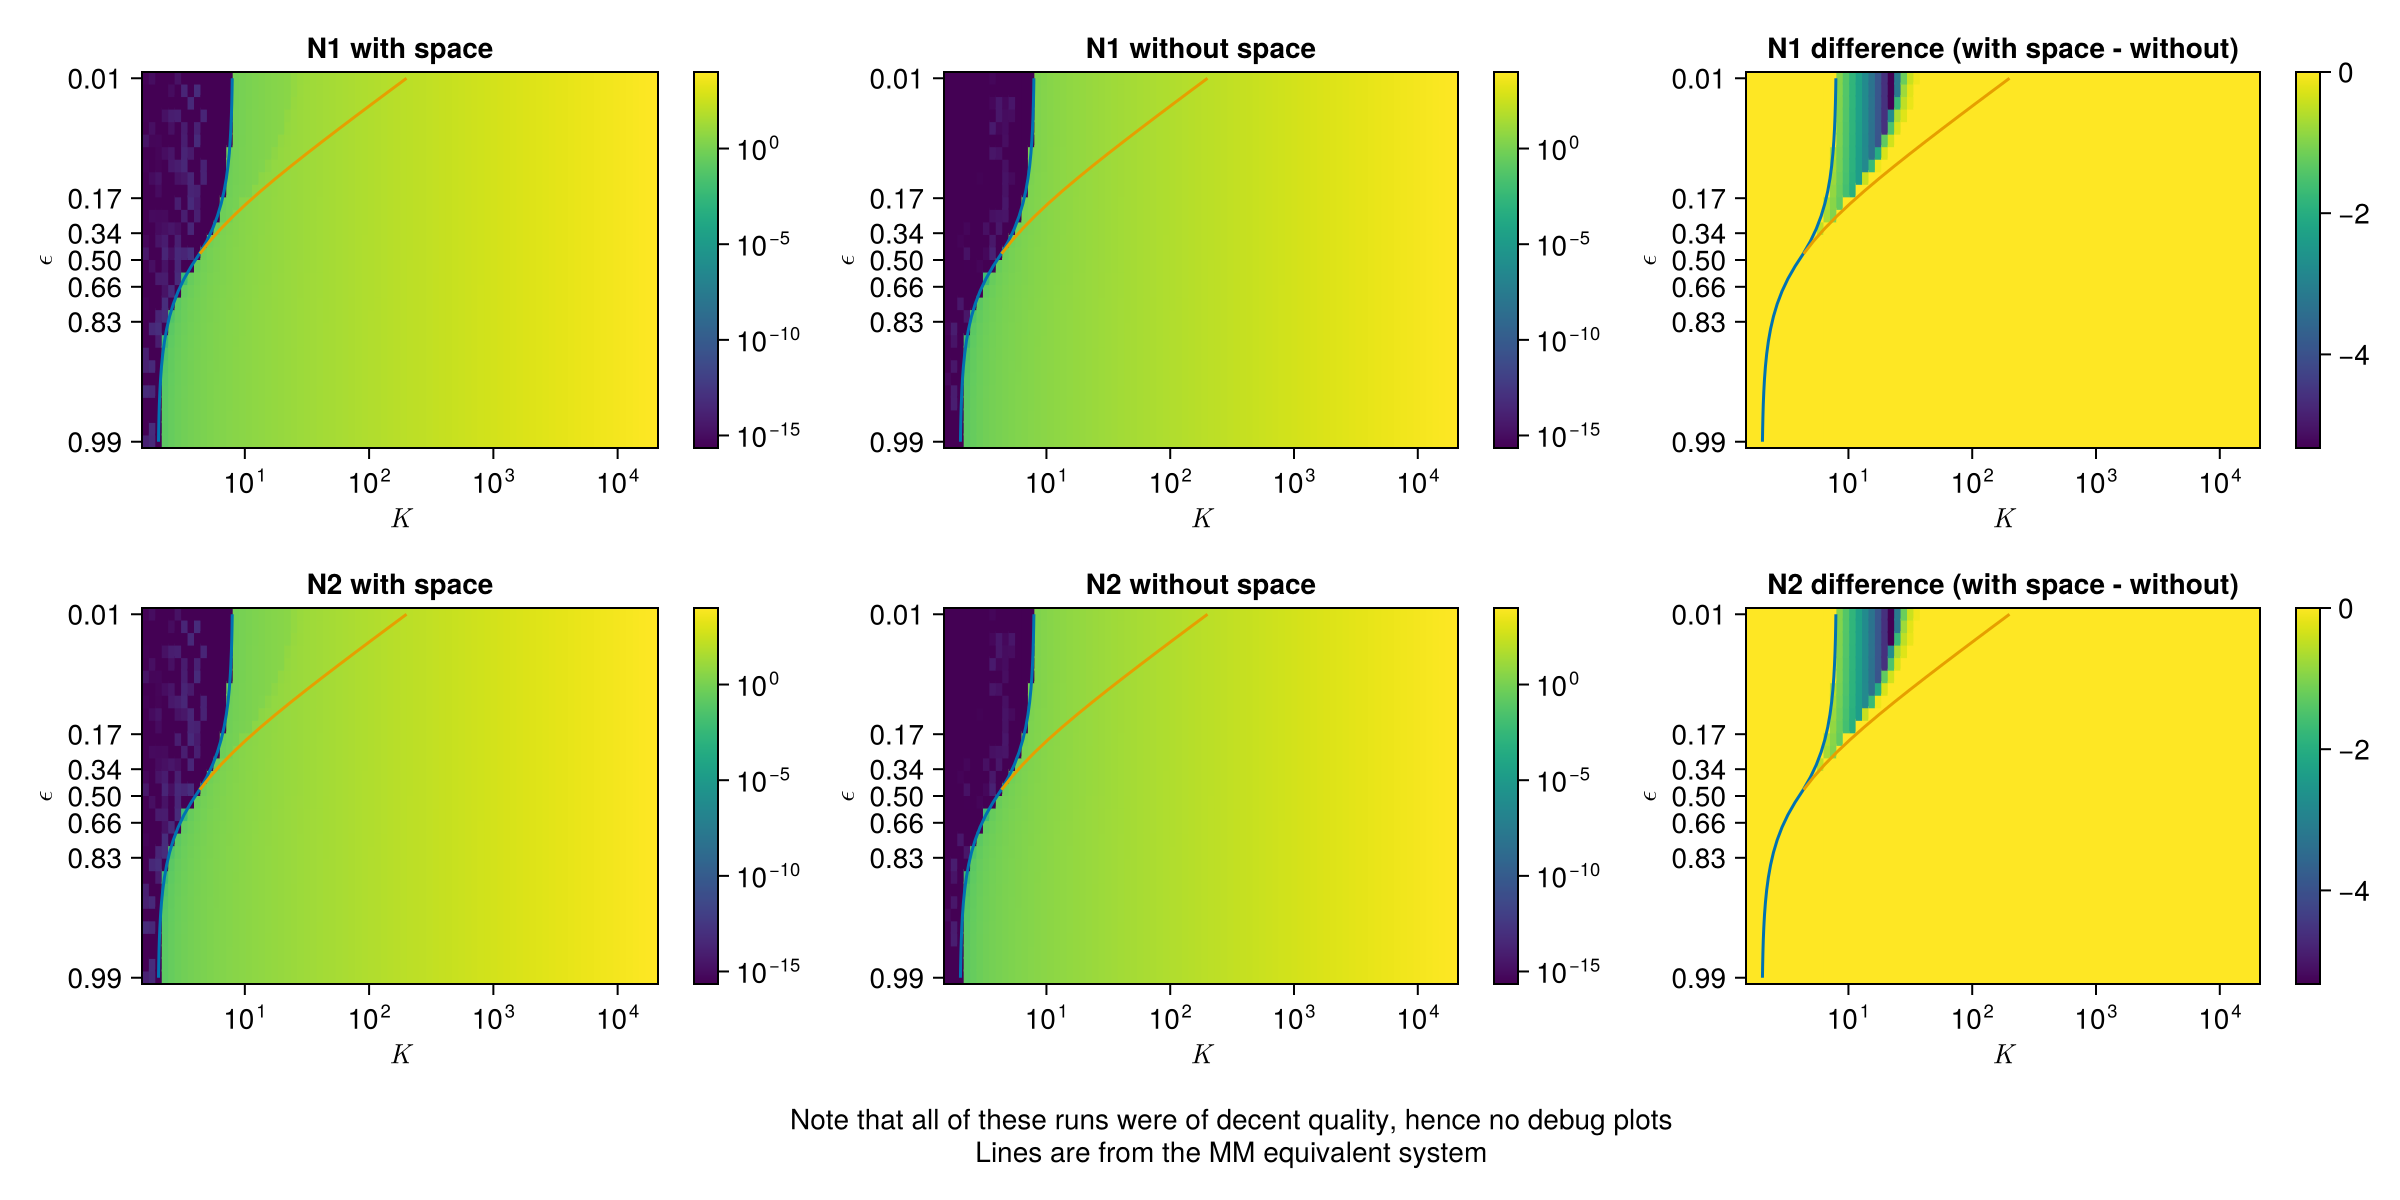

In [14]:
fig = Figure(;
    size=(1200, 600)
)

function faf(place, data, title=""; logscale=true)
    gl = GridLayout(place)
    ax = make_hm_ax(gl[1,1], f;
        title
    )
    hm = if logscale
        draw_log10colorscale_hm!(ax, Ks, leak_xs, data)
    else
        heatmap!(ax, Ks, leak_xs, data)
    end
    draw_scequiv_fr_lines!(ax, ls, f["m"], f["c"])
    Colorbar(gl[1,2], hm)
end
faf(fig[1,1], getindex.(mfss, 1), "N1 with space")
faf(fig[2,1], getindex.(mfss, 2), "N2 with space")
faf(fig[1,2], getindex.(nsfss, 1), "N1 without space")
faf(fig[2,2], getindex.(nsfss, 2), "N2 without space")
faf(fig[1,3], getindex.(mfss, 1) .- getindex.(nsfss, 1), "N1 difference (with space - without)"; logscale=false)
faf(fig[2,3], getindex.(mfss, 2) .- getindex.(nsfss, 2), "N2 difference (with space - without)"; logscale=false)

Label(fig[3,:], "Note that all of these runs were of decent quality, hence no debug plots\nLines are from the MM equivalent system")

Makie.save("./biomass_base.pdf", fig)

fig

## Showing the unstable region via std

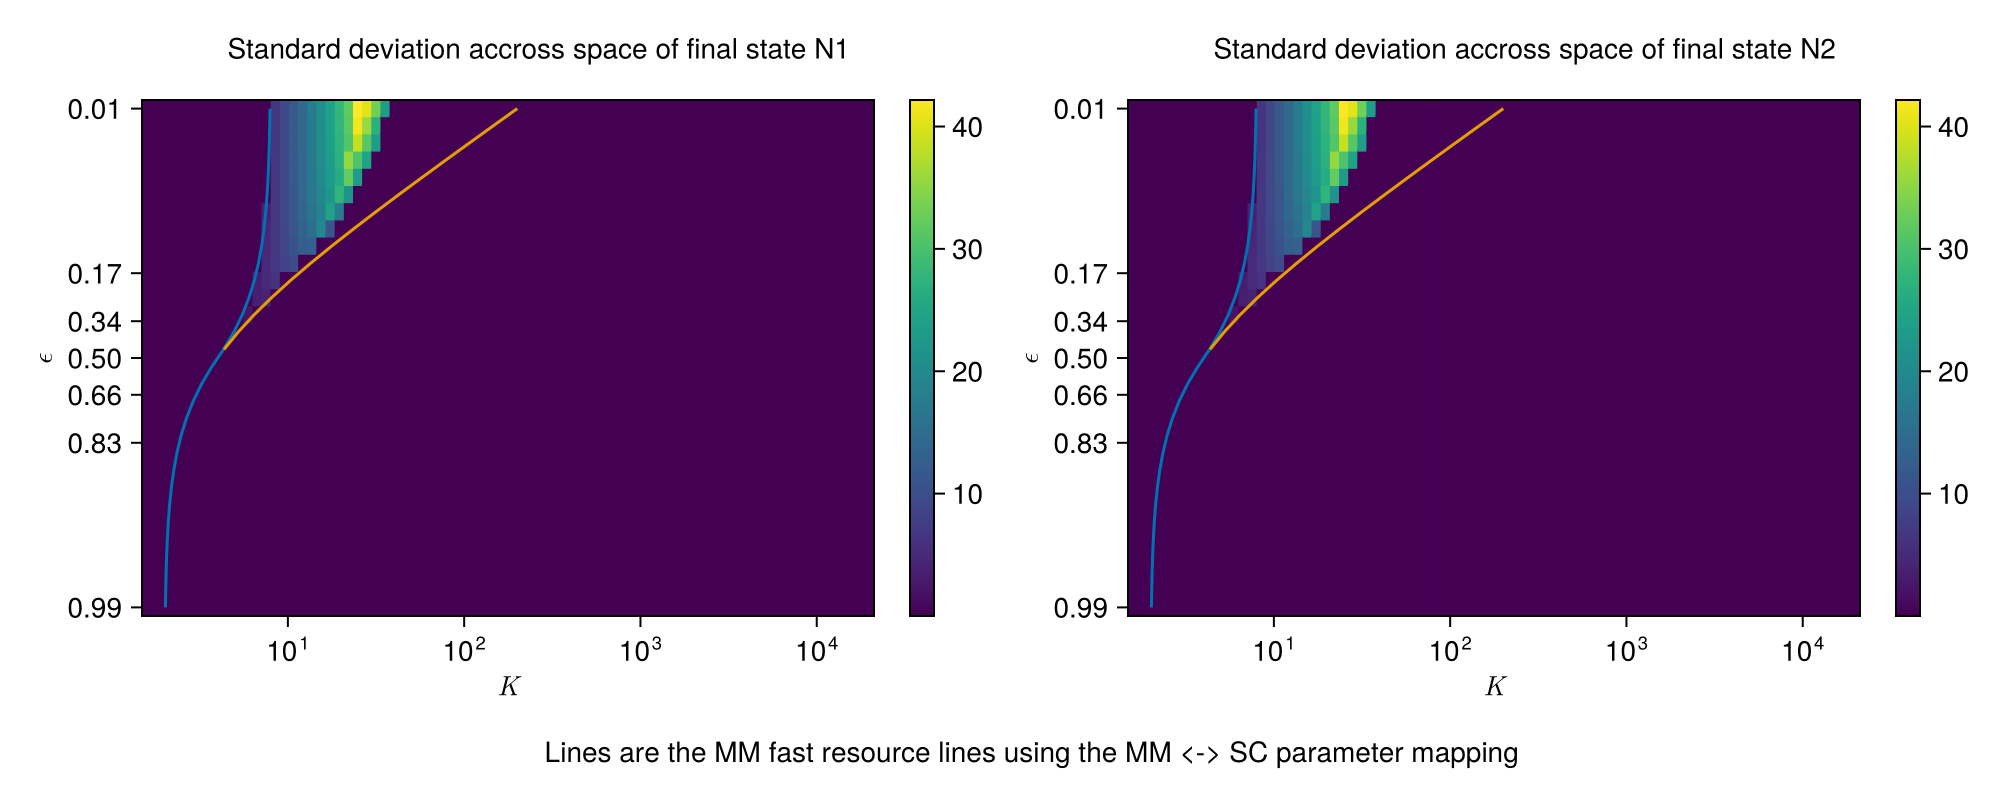

In [150]:
fig = Figure(; size=(1000, 400))

for i in [1, 2]
    gl = GridLayout(fig[1,i])
    ax = make_hm_ax(gl[1,1], f)
    hm = heatmap!(ax, Ks, leak_xs, getindex.(stdfss, i))
    draw_scequiv_fr_lines!(ax, f["ls"], f["m"], f["c"])
    Colorbar(gl[1,2], hm)
    Label(gl[0,:], "Standard deviation accross space of final state N$i")
end

Label(fig[2,:], "Lines are the MM fast resource lines using the MM <-> SC parameter mapping")

fig